In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [3]:
%load_ext autoreload
%autoreload 2

from bs_helpers import *
from utils import *

In [8]:

def create_sea_ships(seed=None):
    'Creates a sea with random ships on it'
    rng = random.Random(seed)
    sea = np.zeros((10,10))
    ships = np.zeros((10,10,4)) # extra information which kind of ship is where
    for k, l in enumerate([5,4,3,2]): # Länge
        n = 6-l # Anzahl
        for _ in range(n):
            # Boot mit Länge l platzieren
            while True:
                t = rng.random() < 0.5
                if t:
                    sea = sea.T # Transponieren
                    ships = ships.transpose(1,0,2)
                px = rng.randint(0, 10-l)
                py = rng.randint(0, 9)
                if sum(sea[px:px+l,py]) > 0:
                    continue
                sea[px:px+l, py] = 1
                ships[px:px+l, py, k] = 1
                if t:
                    sea = sea.T # Transponieren
                    ships = ships.transpose(1,0,2)
                break
    return sea, ships


In [9]:
def encode_x(sea, det):
    'Encodes the visible information to an input to the neural network'
    return np.stack([(1-sea)*det, (1-det), sea*det], -1)
    

def batchgen(size=50):
    while True:
        xs, ys1, ys2 = [], [], []
        for _ in range(size):
            sea, ships = create_sea_ships()
            r = np.random.rand()
            if r < 0.25:
                det = np.random.rand(10,10) < np.random.rand()
            elif r < 0.5:
                det = np.random.rand(10,10) < 1/30*np.random.rand()
            elif r < 0.75:
                det = np.random.rand(10,10) < 1/6*np.random.rand()
            else:
                det = np.random.rand(10,10) < 0.5*np.random.rand()
            x = encode_x(sea, det)
            xs.append(x)
            ys1.append(sea.reshape((10,10,1)))
            ys2.append(ships)
        yield np.array(xs), np.asarray(ys1), np.asarray(ys2)
        

## GAN
Sea ist teilweise vom Fog of war verdeckt, dieser Teil soll durch eine GAN zufällig rekonstruiert werden.

In [13]:
random_dim = 128
input_dim = 3*10*10

# Taken from MNIST-GAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(input_dim+random_dim, 512, normalize=False),
            *block(512, 1024),
            *block(1024, 2048),
            *block(2048, 2048),
            nn.Linear(2048, 10*10*4),
            nn.Sigmoid()
        )

    def forward(self, x, z):
        b, h, w, c = x.shape
        x = x.view(b, -1) 
        out = self.model( torch.cat((x, z), 1) )
        out = out.view(b, h, w, 4)
        return out
    
lrelu = nn.LeakyReLU(0.2)
sigmoid = nn.Sigmoid()
class Discriminator(nn.Module):
    def __init__(self, n=32):
        super(Discriminator, self).__init__()
        
        sn = torch.nn.utils.spectral_norm
        
        self.conv1 = sn(nn.Conv2d(3+4, n, 3, padding=1))
        self.conv2 = sn(nn.Conv2d(n, 2*n, 2, stride=2)) # 5x5
        self.conv3 = sn(nn.Conv2d(2*n, 2*n, 2, stride=2, padding=1)) # 3x3
        self.lin1 = sn(nn.Linear(2*n*3*3, 256))
        self.lin2 = sn(nn.Linear(256, 1))

    def forward(self, x, y):
        b, h, w, c = x.shape
        x  =  x.permute([0, 3, 1, 2])
        y = y.permute([0, 3, 1, 2])
        
        x = torch.cat((x, y), 1)
        x = lrelu(self.conv1(x))
        x = lrelu(self.conv2(x))
        x = lrelu(self.conv3(x))
        x = x.reshape(b, -1)
        x = lrelu(self.lin1(x))
        x = self.lin2(x)
        
        return x
    
    

'''class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        sn = torch.nn.utils.spectral_norm
        self.model = nn.Sequential(
            sn(nn.Linear(4*10*10, 2048)),
            nn.LeakyReLU(0.2, inplace=True),
            sn(nn.Linear(2048, 512)),
            nn.LeakyReLU(0.2, inplace=True),
            sn(nn.Linear(512, 1)),
        )

    def forward(self, x, y):
        b, h, w, c = x.shape
        x = x.view(b, -1)
        y = y.view(b, -1)
        t = self.model( torch.cat((x, y), 1) )

        return t'''
    
    

gen = Generator()
dis = Discriminator()
gen.cuda()
dis.cuda()
gen.optim = torch.optim.Adam(lr=1e-4, betas=(0.5, 0.99), params=gen.parameters())
dis.optim = torch.optim.Adam(lr=1e-4, betas=(0.5, 0.99), params=dis.parameters())

gen.losses = []
dis.losses = []
gen.iters = 0

  0%|          | 0/9999999 [00:00<?, ?it/s]

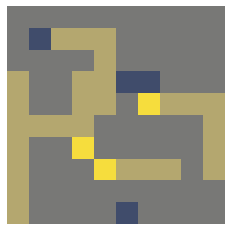

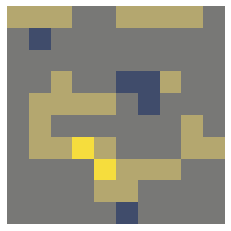

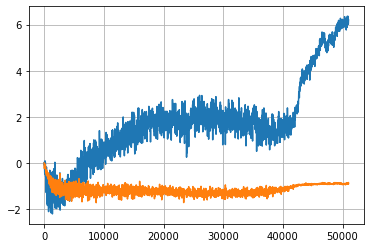

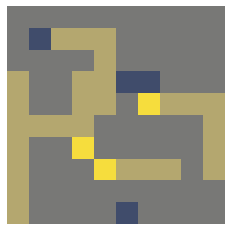

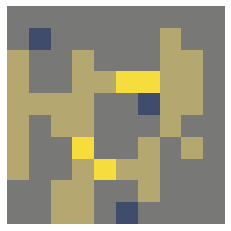

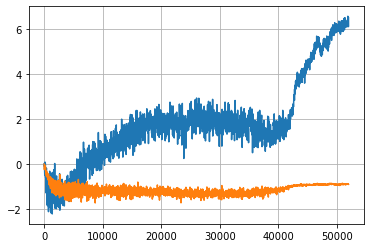

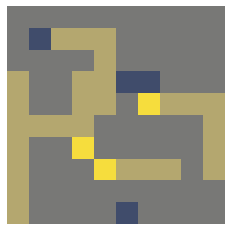

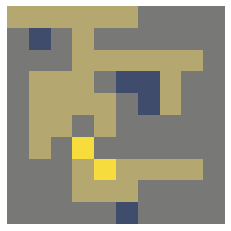

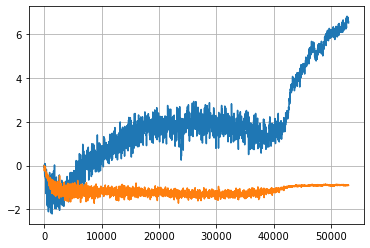

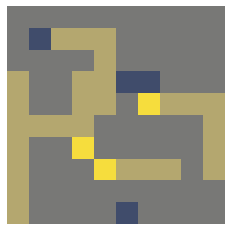

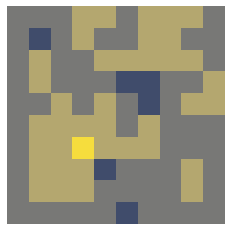

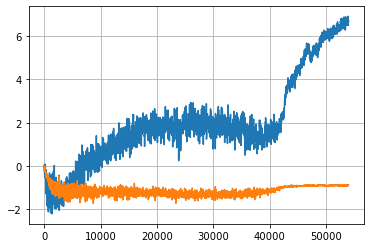

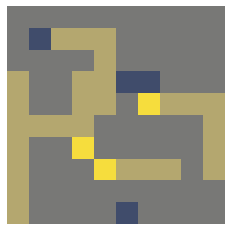

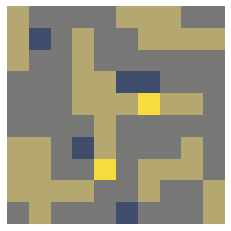

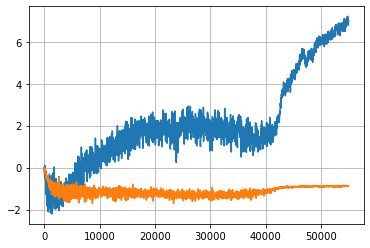

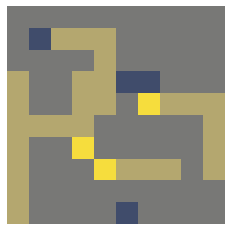

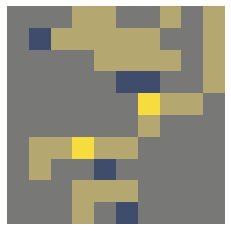

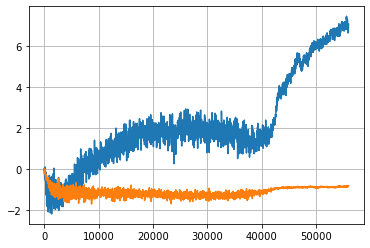

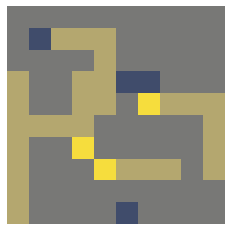

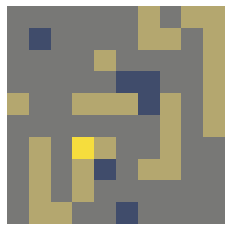

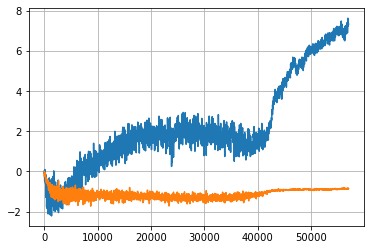

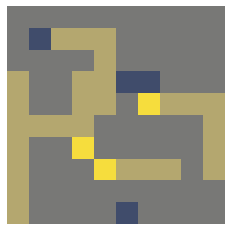

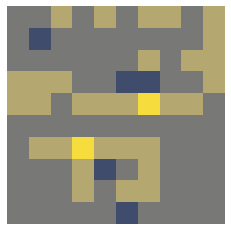

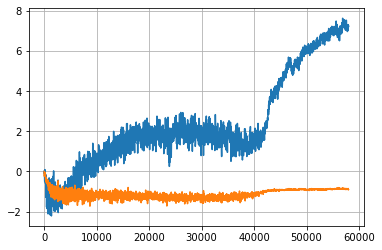

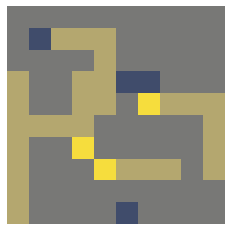

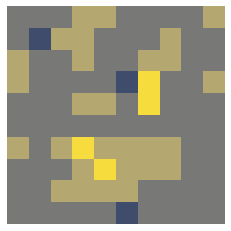

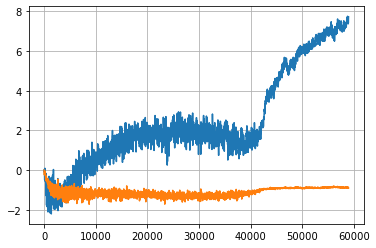

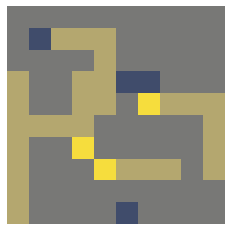

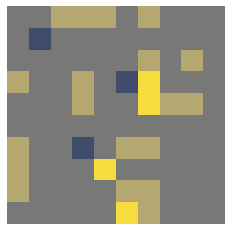

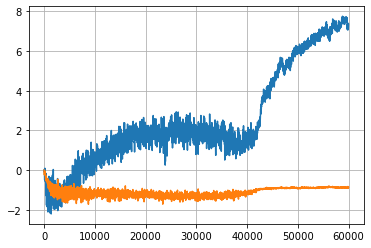

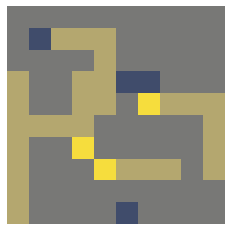

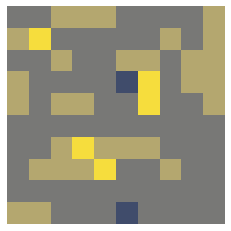

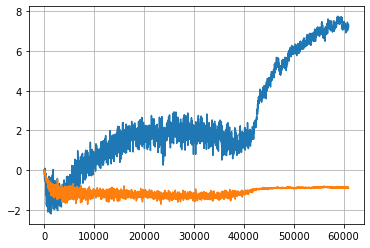

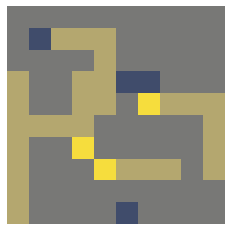

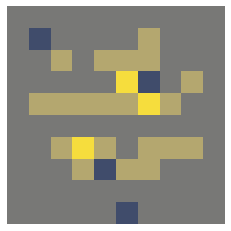

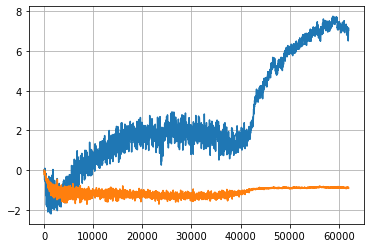

In [ ]:
from tqdm.notebook import trange

batch_size = 64
bgen = batchgen(size=batch_size)

rl_gen = []
rl_dis = []

for k in trange(9999999):
    
    x, _, yt = next(bgen)
    z = np.random.randn(batch_size, random_dim)
    x, yt, z = np2t(x, yt, z)
    
    # generator
    gen.zero_grad()
    yp = gen(x, z)
    dp = dis(x, yp)
    loss_g = dp.mean()
    loss_g.backward()
    gen.optim.step()
    
    # discriminator
    dis.zero_grad()
    yp = yp.detach()
    dp = dis(x, yp)
    dt = dis(x, yt)
    loss_d = dt.mean() - dp.mean()
    loss_d.backward()
    dis.optim.step()
    
    # Statistics
    rl_gen += [loss_g.item()]
    rl_dis += [loss_d.item()]
    
    #print(gen.iters)
    
    # Losses
    if gen.iters % 20 == 0:
        gen.losses += [(gen.iters, np.mean(rl_gen))]
        dis.losses += [(gen.iters, np.mean(rl_dis))]
        rl_gen = []
        rl_dis = []

    # Pictures
    if gen.iters % 1000 == 0:
        gen.eval()
        sea = create_sea(0)
        det = np.zeros((10,10))
        det[1,1]=det[3,5]=det[4,6]=det[7,4]=det[3,6]=det[6,3]=det[9,5]=1
        plot_sea(sea,det)
        plt.show()
        x = encode_x(sea,det)[None]
        z = np.random.randn(1,random_dim)
        yp = gen(*np2t(x,z))
        yp = np.sum(t2np(yp)[0,:,:,:], -1) > 0.5
        plot_sea(yp,det)
        plt.show()
        gen.train()
        
        plt.plot(*zip(*gen.losses))
        plt.plot(*zip(*dis.losses))
        plt.grid()
        plt.show()

    gen.iters += 1
    
    
    #break

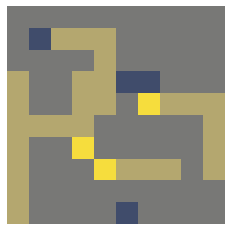

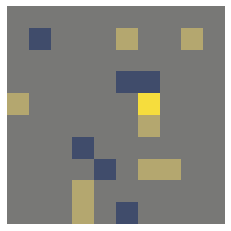

In [25]:
# Beipsiel anzeigen
gen.eval()
sea = create_sea(0)
det = np.zeros((10,10))
det[1,1]=det[3,5]=det[4,6]=det[7,4]=det[3,6]=det[6,3]=det[9,5]=1
plot_sea(sea,det)
plt.show()
x = encode_x(sea,det)[None]
z = np.random.randn(1,random_dim)
yp = gen(*np2t(x,z))
yp = t2np(yp)[0]
yp1 = np.sum(yp, -1) > 0.5
plot_sea(yp1,det)
gen.train();

plot_sea(yp[:,:,3]>.5, det)

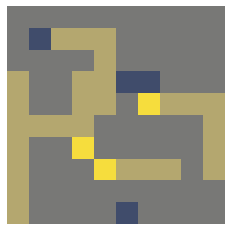

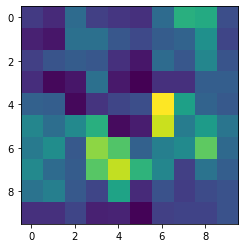

In [62]:
# Beipsiel anzeigen
gen.eval()
sea = create_sea(0)
det = np.zeros((10,10))
det[1,1]=det[3,5]=det[4,6]=det[7,4]=det[3,6]=det[6,3]=det[9,5]=1
plot_sea(sea,det)
plt.show()
yps = []
for _ in range(100):
    x = encode_x(sea,det)[None]
    z = np.random.randn(1,random_dim)
    yp = gen(*np2t(x,z))
    yp = t2np(yp)[0,:,:,0] > 0.5
    #plot_sea(yp,det)
    yps.append(yp)
gen.train();

plt.imshow(np.mean(yps, 0))

In [59]:
np.mean(yps, 0).shape

(10, 10)